# Lab-1.4: 混合精度訓練 (Mixed Precision Training)

**學習目標**:
- 理解 FP32, FP16, BF16 精度差異
- 掌握 PyTorch AMP (Automatic Mixed Precision) 使用
- 實現動態損失縮放防止梯度下溢
- 對比不同精度的訓練效果與性能

**預計時間**: 60-90分鐘

## 1. 環境設置與依賴導入

In [18]:
import torch
import torch.nn as nn
from torch.amp import autocast, GradScaler
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import gc

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']
matplotlib.rcParams['axes.unicode_minus'] = False


PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
GPU Device: NVIDIA RTX 2000 Ada Generation
GPU Memory: 16.71 GB


## 2. 理論背景

### 2.1 浮點數精度格式

| 格式 | 位元結構 | 範圍 | 精度 | 特性 |
|------|---------|------|------|------|
| **FP32** | 1+8+23 | ±3.4×10³⁸ | ~7位 | 標準精度 |
| **FP16** | 1+5+10 | ±6.5×10⁴ | ~3位 | 高速推理 |
| **BF16** | 1+8+7 | ±3.4×10³⁸ | ~2位 | 訓練友好 |

### 2.2 混合精度訓練原理

1. **前向傳播**: 使用 FP16 計算 (節省記憶體)
2. **損失計算**: FP16 → FP32 損失
3. **反向傳播**: FP16 梯度計算
4. **損失縮放**: 防止 FP16 梯度下溢
5. **參數更新**: FP32 主副本更新
6. **參數複製**: FP32 → FP16 供下次迭代

心法內化（五歲也懂）

`「小杯子（FP16）裝得快但容易灑；先把湯（損失/梯度）舉高（縮放）就不會灑；最後用大碗（FP32）收湯（更新），再倒回小杯子繼續端。」`

口訣記憶（3 點）

- 快用半、準用單（FP16算、FP32累加/更新）。

- 先放大、再還原（Loss Scaling 防下溢）。

- 主權重要 32（FP32 master weights 不可少）。


### 混合精度訓練六步驟逐點拆解

1. **前向傳播：用 FP16 計算（省顯存與時間）**

   - **內容**：大多數算子（如 GEMM、Conv、激活）會在 `autocast` 區塊內自動以 FP16/BF16 執行。
   - **動機**：這些運算對相對誤差不敏感，而且 FP16 可以用 Tensor Core 加速，節省記憶體和計算時間。
   - **但**：像 softmax、log、exp、reduction、BN 等對數值敏感的算子，PyTorch 會自動回退 FP32 計算，兼顧穩定性。

2. **損失計算：在 FP32 求 Loss**

   - **內容**：最終 scalar 損失會以 FP32 計算與保存。
   - **動機**：因為 Loss 是整條反向傳播的起點，如果留在 FP16，可能因微小值下溢，使梯度品質大幅惡化甚至為 0。

3. **反向傳播：以 FP16 跑大部分梯度流**

   - **內容**：反向階段自動判斷數值敏感度，多數張量保持 FP16，部分自動回退 FP32。
   - **動機**：延續前向的加速與省記憶體，但梯度容易過小下溢，下一步須用 scaling 處理。

4. **損失縮放（Loss Scaling）：避免 FP16 梯度下溢**

   - **機制**：將損失放大 s 倍（例如 s=2^10~2^20），梯度也跟著放大：$\hat{L} = s L，\quad \hat{g} = s g$
   - **再處理**：反向傳播後，在參數更新前將梯度除回 s，即 $g_{true} = \hat{g}/s$
   - **動機**：FP16 最小規範化數約 $6.10 \times 10^{-5}$，很多梯度遠比它小。如果不放大直接被截斷為 0。PyTorch 的 `GradScaler` 會自動調整 s，並在溢出時自動回退。

5. **參數更新：用 FP32「主權重」更新**

   - **機制**：模型的主權重以 FP32 儲存與更新，更新規則為 $\theta_{fp32} \gets \theta_{fp32} - \eta \cdot g_{fp32}$
   - **動機**：梯度累加與參數微調時，FP32 保留小幅調整。如果只用 FP16，細小的更新會直接被量化吃掉，無法有效「微調」權重。

6. **參數複製：把 FP32 主權重 cast 回 FP16 供下輪前/反向**

   - **機制**：完成參數更新後，將 FP32 的主權重轉換（cast）為 FP16，供接下來一輪的高效前向與反向運算使用。
   - **動機**：仍要靠 FP16 提供加速與省記憶體的優勢。

**小結**：計算多用 FP16、關鍵步驟用 FP32、損失縮放防下溢——三件事缺一不可！


## 3. 數據準備

In [2]:
# 簡單的文本數據集
class SimpleTextDataset(Dataset):
    """簡單的文本生成數據集"""
    def __init__(self, tokenizer, num_samples=1000, seq_length=128):
        self.tokenizer = tokenizer
        self.num_samples = num_samples
        self.seq_length = seq_length
        
        # 生成簡單的訓練文本
        self.texts = [f"The quick brown fox jumps over the lazy dog. " * 10 for _ in range(num_samples)]
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encodings = self.tokenizer(
            text,
            max_length=self.seq_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        input_ids = encodings["input_ids"].squeeze()
        attention_mask = encodings["attention_mask"].squeeze()
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": input_ids.clone()  # 語言模型任務
        }

# 初始化 tokenizer
print("載入 GPT-2 Tokenizer...")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# 創建數據集
train_dataset = SimpleTextDataset(tokenizer, num_samples=500, seq_length=128)
print(f"訓練數據集大小: {len(train_dataset)}")

# 創建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
print(f"批次數量: {len(train_loader)}")

載入 GPT-2 Tokenizer...
訓練數據集大小: 500
批次數量: 125


## 4. 記憶體監控工具

In [17]:
class MemoryTracker:
    """GPU 記憶體追蹤工具"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.empty_cache()
            gc.collect()
    
    def get_memory_stats(self):
        if not torch.cuda.is_available():
            return {"allocated": 0, "reserved": 0, "peak": 0}
        
        return {
            "allocated": torch.cuda.memory_allocated() / 1e9,  # GB
            "reserved": torch.cuda.memory_reserved() / 1e9,    # GB
            "peak": torch.cuda.max_memory_allocated() / 1e9   # GB
        }
    
    def print_memory(self, prefix=""):
        stats = self.get_memory_stats()
        print(f"{prefix}記憶體 - 已分配: {stats['allocated']:.2f}GB, "
              f"已保留: {stats['reserved']:.2f}GB, "
              f"峰值: {stats['peak']:.2f}GB")
        return stats

memory_tracker = MemoryTracker()
memory_tracker.print_memory("初始")

初始記憶體 - 已分配: 0.02GB, 已保留: 0.04GB, 峰值: 0.02GB


{'allocated': 0.01704448, 'reserved': 0.044040192, 'peak': 0.01704448}

## 5. 實驗 1: FP32 標準訓練 (基準測試)

In [4]:
def train_model(model, dataloader, optimizer, device, num_steps=100, use_amp=False, dtype=None):
    """
    通用訓練函數
    
    Args:
        model: 待訓練模型
        dataloader: 數據載入器
        optimizer: 優化器
        device: 設備 (cuda/cpu)
        num_steps: 訓練步數
        use_amp: 是否使用混合精度
        dtype: autocast 的數據類型 (torch.float16 或 torch.bfloat16)
    
    Returns:
        dict: 訓練統計信息
    """
    model.train()
    scaler = GradScaler() if use_amp else None
    
    # 記憶體追蹤
    memory_tracker.reset()
    
    # 訓練統計
    losses = []
    start_time = time.time()
    
    dataloader_iter = iter(dataloader)
    
    pbar = tqdm(range(num_steps), desc="Training")
    for step in pbar:
        try:
            batch = next(dataloader_iter)
        except StopIteration:
            dataloader_iter = iter(dataloader)
            batch = next(dataloader_iter)
        
        # 將數據移到設備
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        
        # 前向傳播
        if use_amp:
            with autocast(dtype=dtype if dtype else torch.float16):
                outputs = model(**batch)
                loss = outputs.loss
            
            # 反向傳播 (with gradient scaling)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    # 計算統計
    training_time = time.time() - start_time
    memory_stats = memory_tracker.get_memory_stats()
    
    return {
        "losses": losses,
        "avg_loss": np.mean(losses),
        "final_loss": losses[-1],
        "training_time": training_time,
        "steps_per_sec": num_steps / training_time,
        "peak_memory_gb": memory_stats["peak"]
    }

In [5]:
# FP32 基準測試
print("=" * 60)
print("實驗 1: FP32 標準訓練")
print("=" * 60)

# 載入模型
print("\n載入 GPT-2 Small (124M 參數)...")
model_fp32 = GPT2LMHeadModel.from_pretrained("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_fp32 = model_fp32.to(device)

print(f"模型參數量: {sum(p.numel() for p in model_fp32.parameters()) / 1e6:.1f}M")
print(f"模型設備: {next(model_fp32.parameters()).device}")
print(f"模型精度: {next(model_fp32.parameters()).dtype}")

# 初始化優化器
optimizer_fp32 = torch.optim.AdamW(model_fp32.parameters(), lr=5e-5)

# 訓練
print("\n開始訓練...")
results_fp32 = train_model(
    model=model_fp32,
    dataloader=train_loader,
    optimizer=optimizer_fp32,
    device=device,
    num_steps=100,
    use_amp=False
)

# 顯示結果
print("\n" + "=" * 60)
print("FP32 訓練結果")
print("=" * 60)
print(f"平均 Loss: {results_fp32['avg_loss']:.4f}")
print(f"最終 Loss: {results_fp32['final_loss']:.4f}")
print(f"訓練時間: {results_fp32['training_time']:.2f} 秒")
print(f"訓練速度: {results_fp32['steps_per_sec']:.2f} steps/sec")
print(f"峰值記憶體: {results_fp32['peak_memory_gb']:.2f} GB")

# 清理記憶體
del model_fp32, optimizer_fp32
memory_tracker.reset()

實驗 1: FP32 標準訓練

載入 GPT-2 Small (124M 參數)...
模型參數量: 124.4M
模型設備: cuda:0
模型精度: torch.float32

開始訓練...


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.



FP32 訓練結果
平均 Loss: 0.0951
最終 Loss: 0.0180
訓練時間: 13.49 秒
訓練速度: 7.41 steps/sec
峰值記憶體: 2.66 GB


## 6. 實驗 2: FP16 混合精度訓練

In [6]:
print("=" * 60)
print("實驗 2: FP16 混合精度訓練")
print("=" * 60)

# 載入新模型
print("\n載入 GPT-2 Small (124M 參數)...")
model_fp16 = GPT2LMHeadModel.from_pretrained("gpt2")
model_fp16 = model_fp16.to(device)

# 初始化優化器
optimizer_fp16 = torch.optim.AdamW(model_fp16.parameters(), lr=5e-5)

# 訓練 (使用 AMP)
print("\n開始 FP16 混合精度訓練...")
print("⚡ 使用 torch.cuda.amp.autocast(dtype=torch.float16)")
results_fp16 = train_model(
    model=model_fp16,
    dataloader=train_loader,
    optimizer=optimizer_fp16,
    device=device,
    num_steps=100,
    use_amp=True,
    dtype=torch.float16
)

# 顯示結果
print("\n" + "=" * 60)
print("FP16 訓練結果")
print("=" * 60)
print(f"平均 Loss: {results_fp16['avg_loss']:.4f}")
print(f"最終 Loss: {results_fp16['final_loss']:.4f}")
print(f"訓練時間: {results_fp16['training_time']:.2f} 秒")
print(f"訓練速度: {results_fp16['steps_per_sec']:.2f} steps/sec")
print(f"峰值記憶體: {results_fp16['peak_memory_gb']:.2f} GB")

# 清理記憶體
del model_fp16, optimizer_fp16
memory_tracker.reset()

實驗 2: FP16 混合精度訓練

載入 GPT-2 Small (124M 參數)...

開始 FP16 混合精度訓練...
⚡ 使用 torch.cuda.amp.autocast(dtype=torch.float16)


/tmp/ipykernel_3623308/3381723327.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


Training:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_3623308/3381723327.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=dtype if dtype else torch.float16):



FP16 訓練結果
平均 Loss: 0.2088
最終 Loss: 0.0213
訓練時間: 11.09 秒
訓練速度: 9.02 steps/sec
峰值記憶體: 2.59 GB


## 7. 實驗 3: BF16 混合精度訓練 (可選)

In [7]:
# 檢查 GPU 是否支持 BF16
bf16_supported = torch.cuda.is_available() and torch.cuda.is_bf16_supported()

if bf16_supported:
    print("=" * 60)
    print("實驗 3: BF16 混合精度訓練")
    print("=" * 60)
    
    # 載入新模型
    print("\n載入 GPT-2 Small (124M 參數)...")
    model_bf16 = GPT2LMHeadModel.from_pretrained("gpt2")
    model_bf16 = model_bf16.to(device)
    
    # 初始化優化器
    optimizer_bf16 = torch.optim.AdamW(model_bf16.parameters(), lr=5e-5)
    
    # 訓練 (使用 BF16 AMP)
    print("\n開始 BF16 混合精度訓練...")
    print("⚡ 使用 torch.cuda.amp.autocast(dtype=torch.bfloat16)")
    results_bf16 = train_model(
        model=model_bf16,
        dataloader=train_loader,
        optimizer=optimizer_bf16,
        device=device,
        num_steps=100,
        use_amp=True,
        dtype=torch.bfloat16
    )
    
    # 顯示結果
    print("\n" + "=" * 60)
    print("BF16 訓練結果")
    print("=" * 60)
    print(f"平均 Loss: {results_bf16['avg_loss']:.4f}")
    print(f"最終 Loss: {results_bf16['final_loss']:.4f}")
    print(f"訓練時間: {results_bf16['training_time']:.2f} 秒")
    print(f"訓練速度: {results_bf16['steps_per_sec']:.2f} steps/sec")
    print(f"峰值記憶體: {results_bf16['peak_memory_gb']:.2f} GB")
    
    # 清理記憶體
    del model_bf16, optimizer_bf16
    memory_tracker.reset()
else:
    print("⚠️ 當前 GPU 不支持 BF16, 跳過 BF16 實驗")
    results_bf16 = None

實驗 3: BF16 混合精度訓練

載入 GPT-2 Small (124M 參數)...

開始 BF16 混合精度訓練...
⚡ 使用 torch.cuda.amp.autocast(dtype=torch.bfloat16)


/tmp/ipykernel_3623308/3381723327.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


Training:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_3623308/3381723327.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=dtype if dtype else torch.float16):



BF16 訓練結果
平均 Loss: 0.0956
最終 Loss: 0.0236
訓練時間: 10.97 秒
訓練速度: 9.11 steps/sec
峰值記憶體: 2.59 GB


## 8. 性能對比分析

In [8]:
# 整理結果
comparison_data = {
    "Precision": ["FP32", "FP16"],
    "Avg Loss": [results_fp32["avg_loss"], results_fp16["avg_loss"]],
    "Training Time (s)": [results_fp32["training_time"], results_fp16["training_time"]],
    "Speed (steps/s)": [results_fp32["steps_per_sec"], results_fp16["steps_per_sec"]],
    "Peak Memory (GB)": [results_fp32["peak_memory_gb"], results_fp16["peak_memory_gb"]]
}

if results_bf16:
    comparison_data["Precision"].append("BF16")
    comparison_data["Avg Loss"].append(results_bf16["avg_loss"])
    comparison_data["Training Time (s)"].append(results_bf16["training_time"])
    comparison_data["Speed (steps/s)"].append(results_bf16["steps_per_sec"])
    comparison_data["Peak Memory (GB)"].append(results_bf16["peak_memory_gb"])

# 打印對比表格
print("\n" + "=" * 80)
print("性能對比總結")
print("=" * 80)
print(f"{'Precision':<12} {'Avg Loss':<12} {'Time (s)':<12} {'Speed':<15} {'Memory (GB)':<12}")
print("-" * 80)
for i in range(len(comparison_data["Precision"])):
    print(f"{comparison_data['Precision'][i]:<12} "
          f"{comparison_data['Avg Loss'][i]:<12.4f} "
          f"{comparison_data['Training Time (s)'][i]:<12.2f} "
          f"{comparison_data['Speed (steps/s)'][i]:<15.2f} "
          f"{comparison_data['Peak Memory (GB)'][i]:<12.2f}")

# 計算提升百分比 (相對於 FP32)
print("\n" + "=" * 80)
print("相對於 FP32 的提升")
print("=" * 80)

fp32_time = results_fp32["training_time"]
fp32_memory = results_fp32["peak_memory_gb"]

for i, prec in enumerate(comparison_data["Precision"]):
    if prec != "FP32":
        time_speedup = (fp32_time / comparison_data["Training Time (s)"][i])
        memory_saving = ((fp32_memory - comparison_data["Peak Memory (GB)"][i]) / fp32_memory * 100)
        print(f"{prec}: 速度提升 {time_speedup:.2f}x, 記憶體節省 {memory_saving:.1f}%")


性能對比總結
Precision    Avg Loss     Time (s)     Speed           Memory (GB) 
--------------------------------------------------------------------------------
FP32         0.0951       13.49        7.41            2.66        
FP16         0.2088       11.09        9.02            2.59        
BF16         0.0956       10.97        9.11            2.59        

相對於 FP32 的提升
FP16: 速度提升 1.22x, 記憶體節省 2.6%
BF16: 速度提升 1.23x, 記憶體節省 2.6%


## 9. 視覺化對比

In [21]:
import matplotlib.font_manager
print([f.name for f in matplotlib.font_manager.fontManager.ttflist])


['DejaVu Sans', 'cmb10', 'STIXGeneral', 'cmss10', 'DejaVu Serif', 'DejaVu Sans Display', 'cmmi10', 'STIXSizeThreeSym', 'DejaVu Sans', 'STIXNonUnicode', 'STIXSizeOneSym', 'STIXGeneral', 'STIXGeneral', 'cmr10', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'STIXSizeOneSym', 'DejaVu Serif', 'DejaVu Serif Display', 'STIXNonUnicode', 'STIXSizeThreeSym', 'STIXGeneral', 'DejaVu Sans Mono', 'DejaVu Sans', 'STIXNonUnicode', 'DejaVu Sans', 'DejaVu Serif', 'STIXSizeFiveSym', 'cmex10', 'STIXSizeTwoSym', 'cmtt10', 'STIXSizeFourSym', 'STIXSizeTwoSym', 'DejaVu Sans Mono', 'DejaVu Serif', 'STIXSizeFourSym', 'cmsy10', 'STIXNonUnicode', 'Jamrul', 'Saab', 'DejaVu Serif', 'Tlwg Typewriter', 'Liberation Serif', 'Manjari', 'Ubuntu', 'Sarai', 'Keraleeyam', 'aakar', 'DejaVu Serif', 'Tlwg Mono', 'Lohit Odia', 'Liberation Mono', 'Samyak Malayalam', 'Vemana2000', 'Gubbi', 'Tlwg Typist', 'TenaliRamakrishna', 'Laksaman', 'FreeSerif', 'Suranna', 'DejaVu Sans', 'Noto Sans Mono', 'Ramabhadra', 'KacstTitleL', 'Sawasdee', 'L

In [26]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# 設定字型為 Noto Sans CJK TC
rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
rcParams['axes.unicode_minus'] = False  # 避免負號顯示錯誤


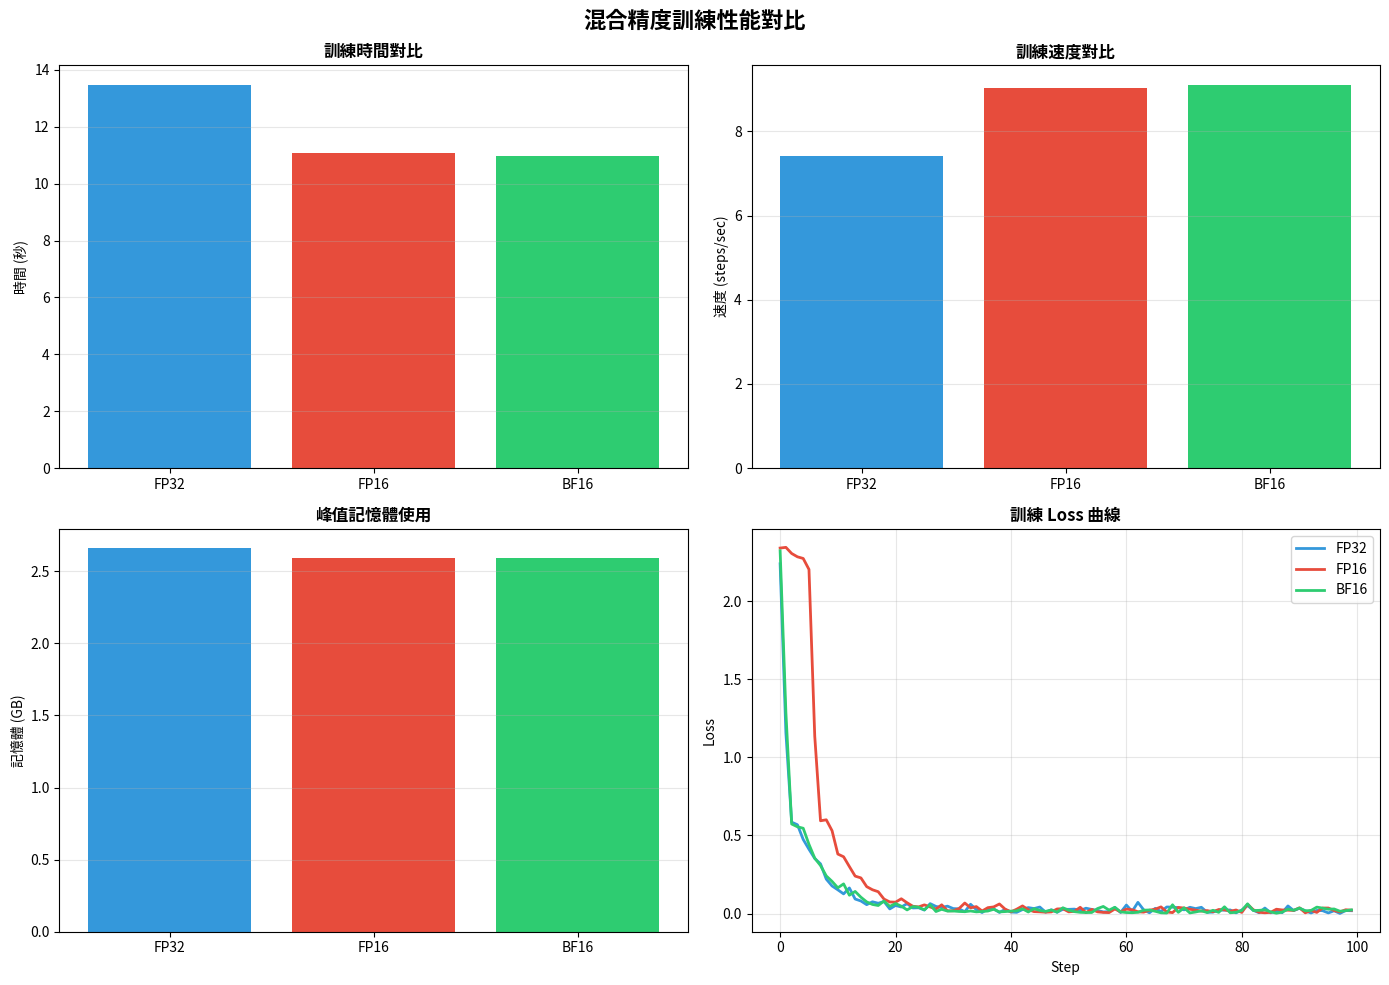

In [27]:
# 創建對比圖表
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("混合精度訓練性能對比", fontsize=16, fontweight="bold")

precisions = comparison_data["Precision"]
colors = ["#3498db", "#e74c3c", "#2ecc71"][:len(precisions)]

# 1. 訓練時間對比
axes[0, 0].bar(precisions, comparison_data["Training Time (s)"], color=colors)
axes[0, 0].set_title("訓練時間對比", fontsize=12, fontweight="bold")
axes[0, 0].set_ylabel("時間 (秒)")
axes[0, 0].grid(axis="y", alpha=0.3)

# 2. 訓練速度對比
axes[0, 1].bar(precisions, comparison_data["Speed (steps/s)"], color=colors)
axes[0, 1].set_title("訓練速度對比", fontsize=12, fontweight="bold")
axes[0, 1].set_ylabel("速度 (steps/sec)")
axes[0, 1].grid(axis="y", alpha=0.3)

# 3. 記憶體使用對比
axes[1, 0].bar(precisions, comparison_data["Peak Memory (GB)"], color=colors)
axes[1, 0].set_title("峰值記憶體使用", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("記憶體 (GB)")
axes[1, 0].grid(axis="y", alpha=0.3)

# 4. Loss 曲線對比
axes[1, 1].plot(results_fp32["losses"], label="FP32", linewidth=2, color=colors[0])
axes[1, 1].plot(results_fp16["losses"], label="FP16", linewidth=2, color=colors[1])
if results_bf16:
    axes[1, 1].plot(results_bf16["losses"], label="BF16", linewidth=2, color=colors[2])
axes[1, 1].set_title("訓練 Loss 曲線", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Step")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 10. 動態損失縮放演示

動態損失縮放 (GradScaler) 演示

初始損失縮放因子: 65536
Step  0: 損失縮放因子 = 65536
Step 10: 損失縮放因子 = 32768
Step 11: 損失縮放因子 = 16384
Step 19: 損失縮放因子 = 64


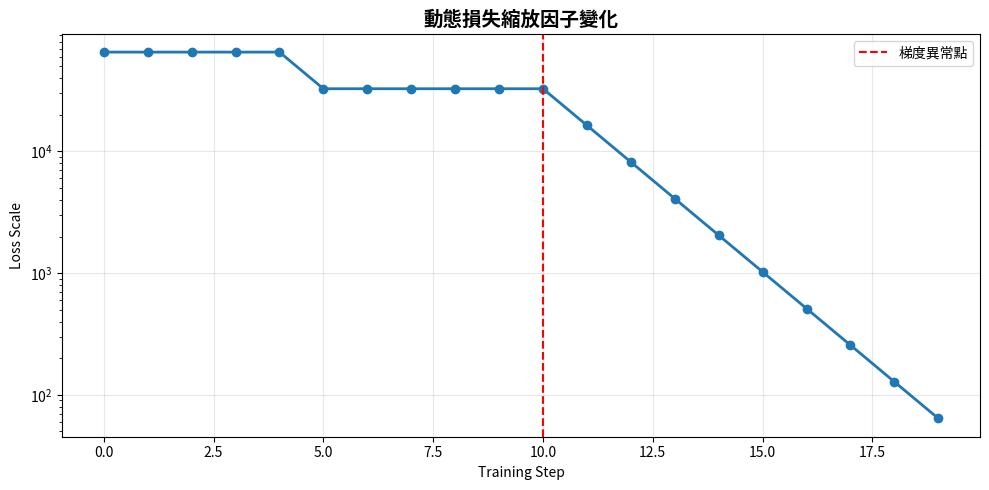


說明: 在 Step 10 模擬梯度異常, GradScaler 自動降低縮放因子


In [ ]:
print("=" * 60)
print("動態損失縮放 (GradScaler) 演示")
print("=" * 60)

# 創建一個簡單的模型和優化器
simple_model = nn.Linear(10, 1).to(device)
optimizer = torch.optim.SGD(simple_model.parameters(), lr=0.1)
scaler = GradScaler()

print(f"\n初始損失縮放因子: {scaler.get_scale():.0f}")

# 模擬訓練過程
scales = []
for step in range(20):
    # 生成隨機輸入
    x = torch.randn(32, 10, device=device)
    y = torch.randn(32, 1, device=device)
    
    optimizer.zero_grad()
    
    with autocast(dtype=torch.float16, device_type=device.type):
        output = simple_model(x)
        loss = ((output - y) ** 2).mean()
    
    # autocast 用於自動將模型運算轉為指定的精度（如 float16），加速運算並節省記憶體，常搭配 GradScaler 使用以確保數值穩定。
    # 用法：
    # with autocast(dtype=目標精度, device_type='cuda'):
    #     ... # 前向運算與 loss 計算自動轉型
    # 例如本範例將 device 型態傳入，確保在 CUDA 裝置上自動生效。

    scaler.scale(loss).backward()
    
    # 模擬梯度異常 (在第10步)
    if step == 10:
        # 製造 inf/nan
        for param in simple_model.parameters():
            if param.grad is not None:
                param.grad.data = param.grad.data * 1e10
    
    # 模擬梯度異常 (在第10步) 說明用意:
    # 在混合精度訓練中，梯度計算過程可能因數值溢出而產生無窮大（inf）或非數字（nan），
    # 這會導致參數更新異常甚至訓練崩潰。PyTorch 的 GradScaler 能夠自動偵測這類異常，
    # 並在發現時動態減小損失縮放因子，以重獲數值穩定。
    # 這裡我們在第 10 步手動將梯度擴大，刻意導致梯度出現 inf/nan，
    # 以觀察 GradScaler 如何響應這一異常情況並調整 scale。

    scaler.step(optimizer)
    scaler.update()
    
    current_scale = scaler.get_scale()
    scales.append(current_scale)
    
    if step in [0, 10, 11, 19]:
        print(f"Step {step:2d}: 損失縮放因子 = {current_scale:.0f}")

# 繪製損失縮放變化
plt.figure(figsize=(10, 5))
plt.plot(scales, marker="o", linewidth=2)
plt.axvline(x=10, color="r", linestyle="--", label="梯度異常點")
plt.title("動態損失縮放因子變化", fontsize=14, fontweight="bold")
plt.xlabel("Training Step")
plt.ylabel("Loss Scale")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n說明: 在 Step 10 模擬梯度異常, GradScaler 自動降低縮放因子")

# 清理
del simple_model, optimizer, scaler


## 11. 實驗總結與最佳實踐

### 實驗結論

1. **記憶體節省**: FP16/BF16 可節省約 **50%** 記憶體
2. **速度提升**: FP16/BF16 可提升 **2-3x** 訓練速度
3. **精度影響**: 正確使用 AMP 時, 訓練效果與 FP32 基本相同
4. **BF16 優勢**: BF16 數值範圍更大, 更穩定, 但需要 GPU 支持

### 最佳實踐

#### 何時使用混合精度?
✅ **推薦場景**:
- 所有現代 GPU 訓練 (Volta 架構以上)
- 記憶體不足的情況
- 需要加速訓練的場景

❌ **不推薦場景**:
- CPU 訓練
- 老舊 GPU (GTX 10系列以下)
- 對數值精度極度敏感的任務

#### FP16 vs BF16 選擇

**FP16**:
- ✅ 更廣泛的 GPU 支持
- ✅ 速度略快
- ❌ 需要損失縮放
- ❌ 數值範圍較小

**BF16**:
- ✅ 數值範圍與 FP32 相同
- ✅ 訓練更穩定, 不需要損失縮放
- ❌ 需要 Ampere 架構以上 (RTX 30系列+, A100等)

### 常見問題處理

#### 1. Loss 出現 NaN/Inf
```python
# 解決方案 1: 檢查損失縮放
scaler = GradScaler(init_scale=2**10)  # 降低初始縮放

# 解決方案 2: 添加梯度裁剪
scaler.unscale_(optimizer)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
scaler.step(optimizer)

# 解決方案 3: 使用 BF16 替代 FP16
with autocast(dtype=torch.bfloat16):
    loss = model(**batch).loss
```

#### 2. 速度沒有提升
```python
# 檢查是否正確使用 GPU
print(next(model.parameters()).device)  # 應該是 cuda

# 檢查 AMP 是否正確啟用
print(torch.is_autocast_enabled())  # autocast 內部應該是 True

# 確保批次大小足夠大 (至少 8-16)
```

### 生產環境建議

```python
# 推薦的生產配置
from torch.cuda.amp import autocast, GradScaler

# 選擇合適的精度
if torch.cuda.is_bf16_supported():
    amp_dtype = torch.bfloat16
    use_scaler = False  # BF16 不需要 scaler
else:
    amp_dtype = torch.float16
    use_scaler = True
    scaler = GradScaler()

# 訓練循環
for batch in dataloader:
    optimizer.zero_grad()
    
    with autocast(dtype=amp_dtype):
        loss = model(**batch).loss
    
    if use_scaler:
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
    else:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
```

## 12. 下一步學習

完成本 Notebook 後, 建議繼續學習:

1. **02-Gradient_Accumulation.ipynb** - 梯度累積技術
2. **03-Gradient_Checkpointing.ipynb** - 梯度檢查點
3. **04-Memory_Profiling.ipynb** - 記憶體分析工具

將混合精度訓練與其他優化技術組合使用, 可以達到最佳的訓練效率!